In [1]:
PROJECT_ID = "text-embeddings-414713"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [2]:
LOCATION = "us-central1"

In [3]:
BUCKET_URI = f"gs://text-embedding-samples-{PROJECT_ID}-unique"

In [4]:
from google.cloud import bigquery
import pandas as pd

In [5]:
def run_bq_query(sql):

    # Create BQ client
    bq_client = bigquery.Client(project = PROJECT_ID, 
                                )

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, 
                                         use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, 
                                    job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

In [6]:

language_list = ["python", "html", "r", "css"]

In [7]:
so_df = pd.DataFrame()

for language in language_list:
    
    print(f"generating {language} dataframe")
    
    query = f"""
    SELECT
        CONCAT(q.title, q.body) as input_text,
        a.body AS output_text
    FROM
        `bigquery-public-data.stackoverflow.posts_questions` q
    JOIN
        `bigquery-public-data.stackoverflow.posts_answers` a
    ON
        q.accepted_answer_id = a.id
    WHERE 
        q.accepted_answer_id IS NOT NULL AND 
        REGEXP_CONTAINS(q.tags, "{language}") AND
        a.creation_date >= "2020-01-01"
    LIMIT 
        500
    """

    
    language_df = run_bq_query(query)
    language_df["category"] = language
    so_df = pd.concat([so_df, language_df], 
                      ignore_index = True) 

generating python dataframe
Finished job_id: 5a6b6259-c010-4a83-b253-d6c921287739
generating html dataframe
Finished job_id: a3213e35-b231-4bd8-af1e-d2116d76201c
generating r dataframe
Finished job_id: 4af829f3-56fc-4e33-8f05-9b99e3ad1541
generating css dataframe
Finished job_id: bd06d574-6a1e-47c7-8d74-31906cada848


In [8]:
so_df

,input_text,output_text,category
0,How to continue adding more json info<p>I'm ma...,<p>You can try with a list from outside the lo...,python
1,Geopandas + rasterio : isolate a vector as png...,<p>We can make the approach crispier by using ...,python
2,Replacing column values with loop result panda...,<p>You could probably just convert it to a <co...,python
3,InvalidArgumentError: StringToNumberOp could n...,<p>It turns out the error was caused by a few ...,python
4,Python code coverage missing when files have t...,"<p>This issue is mentioned <a href=""https://gi...",python
...,...,...,...
1995,How to target the nth-of-type of an element us...,<p>You could look at this a bit different: you...,css
1996,Column flow with fixed number of columns?<p>I ...,<pre><code>&lt;ul style=&quot;column-count:2;&...,css
1997,Why does the font-size change for container bi...,<p>I looked on the apple.com web page to see i...,css
1998,Get mat-icon element by icon name in css?<p>I ...,<p><strong>Short answer:</strong>\nunfortunate...,css


#### Generate text embeddings
- To generate embeddings for a dataset of texts, we'll need to group the sentences together in batches and send batches of texts to the model.
- The API currently can take batches of up to 5 pieces of text per API call.

In [9]:
from vertexai.language_models import TextEmbeddingModel

In [11]:
model = TextEmbeddingModel.from_pretrained(
    "textembedding-gecko@001")

In [12]:
import time
import numpy as np

In [13]:
# Generator function to yield batches of sentences

def generate_batches(sentences, batch_size = 5):
    for i in range(0, len(sentences), batch_size):
        yield sentences[i : i + batch_size]

In [14]:
so_questions = so_df[0:200].input_text.tolist() 
batches = generate_batches(sentences = so_questions)

In [15]:
batch = next(batches)
len(batch)

5

#### Get embeddings on a batch of data
- This helper function calls `model.get_embeddings()` on the batch of data, and returns a list containing the embeddings for each text in that batch.

In [16]:
def encode_texts_to_embeddings(sentences):
    try:
        embeddings = model.get_embeddings(sentences)
        return [embedding.values for embedding in embeddings]
    except Exception:
        return [None for _ in range(len(sentences))]

In [17]:
batch_embeddings = encode_texts_to_embeddings(batch)

In [18]:
f"{len(batch_embeddings)} embeddings of size \
{len(batch_embeddings[0])}"

'5 embeddings of size 768'

### Load data from a file

In [19]:
!ls ./data

question_embeddings_app.pkl so_database_app.csv


In [20]:
so_df = pd.read_csv('./data/so_database_app.csv')
so_df.head()

,input_text,output_text,category
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python


In [21]:
import pickle

In [22]:
with open('./data/question_embeddings_app.pkl', 'rb') as file:
    question_embeddings = pickle.load(file)

In [23]:
print("Shape: " + str(question_embeddings.shape))
print(question_embeddings)

Shape: (2000, 768)
[[-0.03571156 -0.00240684  0.05860338 ... -0.03100227 -0.00855574
  -0.01997405]
 [-0.02024316 -0.0026255   0.01940405 ... -0.02158143 -0.05655403
  -0.01040497]
 [-0.05175979 -0.03712264  0.02699278 ... -0.07055898 -0.0402537
   0.00092099]
 ...
 [-0.00580394 -0.01621097  0.05829635 ... -0.03350992 -0.05343556
  -0.06016821]
 [-0.00436622 -0.02692963  0.03363771 ... -0.01686567 -0.03812337
  -0.02329491]
 [-0.04240424 -0.01633749  0.05516777 ... -0.02697376 -0.01751165
  -0.04558187]]


In [24]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [25]:
clustering_dataset = question_embeddings[:1000]

In [26]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, 
                random_state=0, 
                n_init = 'auto').fit(clustering_dataset)

In [27]:
kmeans_labels = kmeans.labels_

In [28]:
PCA_model = PCA(n_components=2)
PCA_model.fit(clustering_dataset)
new_values = PCA_model.transform(clustering_dataset)

In [29]:
import matplotlib.pyplot as plt
import mplcursors
%matplotlib ipympl

In [30]:
def clusters_2D(x_values, y_values, labels, kmeans_labels):
    fig, ax = plt.subplots()
    scatter = ax.scatter(x_values, 
                         y_values, 
                         c = kmeans_labels, 
                         cmap='Set1', 
                         alpha=0.5, 
                         edgecolors='k', 
                         s = 40)  # Change the denominator as per n_clusters

    # Create a mplcursors object to manage the data point interaction
    cursor = mplcursors.cursor(scatter, hover=True)

    #axes
    ax.set_title('Embedding clusters visualization in 2D')  # Add a title
    ax.set_xlabel('X_1')  # Add x-axis label
    ax.set_ylabel('X_2')  # Add y-axis label

    # Define how each annotation should look
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(labels.category[sel.target.index])
        sel.annotation.get_bbox_patch().set(facecolor='white', alpha=0.95) # Set annotation's background color
        sel.annotation.set_fontsize(14) 

    plt.show()

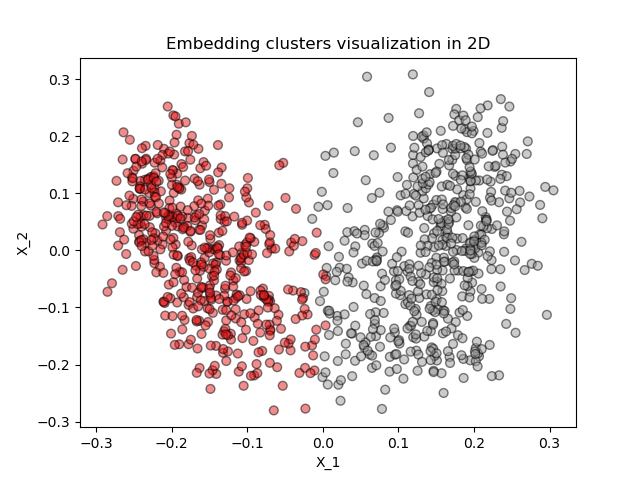

In [31]:
#from utils import clusters_2D
clusters_2D(x_values = new_values[:,0], y_values = new_values[:,1], 
            labels = so_df[:1000], kmeans_labels = kmeans_labels)

## Anomaly / Outlier detection

- We can add an anomalous piece of text and check if the outlier (anomaly) detection algorithm (Isolation Forest) can identify it as an outlier (anomaly), based on its embedding.

In [32]:
from sklearn.ensemble import IsolationForest

In [33]:
input_text = """I am making cookies but don't 
                remember the correct ingredient proportions. 
                I have been unable to find 
                anything on the web."""

In [34]:
emb = model.get_embeddings([input_text])[0].values

In [35]:
embeddings_l = question_embeddings.tolist()
embeddings_l.append(emb)

In [36]:
embeddings_array = np.array(embeddings_l)

In [40]:
print("Shape: " + str(embeddings_array.shape))
print(embeddings_array)

Shape: (2001, 768)
[[-0.03571156 -0.00240684  0.05860338 ... -0.03100227 -0.00855574
  -0.01997405]
 [-0.02024316 -0.0026255   0.01940405 ... -0.02158143 -0.05655403
  -0.01040497]
 [-0.05175979 -0.03712264  0.02699278 ... -0.07055898 -0.0402537
   0.00092099]
 ...
 [-0.00436622 -0.02692963  0.03363771 ... -0.01686567 -0.03812337
  -0.02329491]
 [-0.04240424 -0.01633749  0.05516777 ... -0.02697376 -0.01751165
  -0.04558187]
 [-0.00302366 -0.02049104  0.02172194 ... -0.04479321 -0.05254056
  -0.00319716]]


In [39]:
# Add the outlier text to the end of the stack overflow dataframe
so_df = pd.read_csv('./data/so_database_app.csv')
new_row = pd.Series([input_text, None, "baking"], 
                    index=so_df.columns)
so_df.loc[len(so_df)+1] = new_row
so_df.tail()

,input_text,output_text,category
1996,Flip Clock code works on Codepen and doesn't w...,<p>You forgot to attach the CSS file for the f...,css
1997,React Native How can I put one view in front o...,<p>You can do it using zIndex for example:</p>...,css
1998,setting fixed width with 100% height of the pa...,<p>You can use <code>width: calc(100% - 100px)...,css
1999,How to make sidebar button not bring viewpoint...,"<p>It is quite simple, just remove that href=""...",css
2001,I am making cookies but don't \n ...,None,baking


In [41]:
clf = IsolationForest(contamination=0.005, 
                      random_state = 2) 

In [42]:
preds = clf.fit_predict(embeddings_array)

print(f"{len(preds)} predictions. Set of possible values: {set(preds)}")

2001 predictions. Set of possible values: {1, -1}


In [43]:
so_df.loc[preds == -1]

,input_text,output_text,category
203,extract channel names from a multi-channel ima...,<p>PerkinElmer QPI metadata are stored as XML ...,python
1018,ASP .NET - JSON Serializer not working on clas...,"<p>Ok, I forgot to add default <code>{ get; se...",r
1138,parse year and month from a string SQL BigQuer...,<p>How about using string operations?</p>\n<pr...,r
1313,Array initialization with ternary operator in ...,"<p>To make your code work, do the following in...",r
1358,How to represent 2 Entity with 2 Relation in E...,"<p><a href=""https://i.stack.imgur.com/BJxBP.pn...",r
1403,"Apache ignite Partition Map Exchange , Baselin...","<p>Long story short, these topics are about da...",r
1427,Shortcut to reveal in Finder for currently ope...,<p>No. It is not present but we can add it. Go...,r
1493,How to change id of datatable?<p>I have some w...,<p>In short - you can't. But maybe you can:</p...,r
1498,What’s the difference between Next.js rewrites...,<p><code>rewrites</code> are a convenient way ...,r
2001,I am making cookies but don't \n ...,None,baking


In [44]:
so_df = so_df.drop(so_df.index[-1])

In [45]:
so_df

,input_text,output_text,category
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python
...,...,...,...
1995,Is it possible to made inline-block elements l...,<p>If this is only for the visual purpose then...,css
1996,Flip Clock code works on Codepen and doesn't w...,<p>You forgot to attach the CSS file for the f...,css
1997,React Native How can I put one view in front o...,<p>You can do it using zIndex for example:</p>...,css
1998,setting fixed width with 100% height of the pa...,<p>You can use <code>width: calc(100% - 100px)...,css


In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [49]:
# re-load the dataset from file
so_df = pd.read_csv('./data/so_database_app.csv')
X = question_embeddings
X.shape

(2000, 768)

In [50]:
y = so_df['category'].values
y.shape

(2000,)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 2)

In [52]:
clf = RandomForestClassifier(n_estimators=200)

In [53]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [54]:
y_pred = clf.predict(X_test)

In [55]:
accuracy = accuracy_score(y_test, y_pred) # compute accuracy
print("Accuracy:", accuracy)

Accuracy: 0.6875


In [56]:
# choose a number between 0 and 1999
i = 2
label = so_df.loc[i,'category']
question = so_df.loc[i,'input_text']

# get the embedding of this question and predict its category
question_embedding = model.get_embeddings([question])[0].values
pred = clf.predict([question_embedding])

print(f"For question {i}, the prediction is `{pred[0]}`")
print(f"The actual label is `{label}`")
print("The question text is:")
print("-"*50)
print(question)

For question 2, the prediction is `python`
The actual label is `python`
The question text is:
--------------------------------------------------
How do we test a specific method written in a list of files for functional testing in python<p>The project has so many modules. There are functional test cases being written for almost every api written like for GET requests, POST requests and PUT requests. To test an individual file we use the syntact pytest tests/file_name.py
but I want to test a specific method in that file. Is there any way to test it like that??</p>
